# Visualization of the mdoel performance on different data portions
It's an update after fixing the data snooping issue (`data_info.ipynb`).

The models are:
1. Fine-tuned from the pre-trained model
1. Trained from scratch
1. Lee et al. (2022)

In [2]:
import glob
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
annotation_files=[
    'info_10.csv',
    'info_50.csv',
    'info_100.csv',
    'info_500.csv',
    'info_1000.csv',
    'info.csv'
]

rows = []

for target in ["CaCO3", "TOC"]:
    if target == "CaCO3":
        data_no_ls = [10, 50, 100, 500, 1000, 1488]
    elif target == "TOC":
        data_no_ls = [10, 50, 100, 500, 1000, 1573]

    if len(annotation_files) != len(data_no_ls):
        print("The number of annotation files and data splits do not match.")
        exit()

    for i in range(len(annotation_files)):
        txt_dir = glob.glob(f"../results/finetune_data_amount/{target}-{annotation_files[i]}*/{target}.txt")
        
        if len(txt_dir) == 1:
            txt = txt_dir[0]
        else:
            print(f"Error: {len(txt_dir)} txt files found for {annotation_files[i]}")
            exit()

        with open(txt, "r") as f:
            words = f.readline().split()
            r_square = float(words[-1])
            rows.append([target, data_no_ls[i], r_square])

df = pd.DataFrame(rows, columns=["target", "data_no", "r2_ft"])
df


,target,data_no,r2_ft
0,CaCO3,10,0.576
1,CaCO3,50,0.903
2,CaCO3,100,0.959
3,CaCO3,500,0.970
4,CaCO3,1000,0.967
5,CaCO3,1488,0.971
6,TOC,10,-0.117
7,TOC,50,0.151
8,TOC,100,0.285
9,TOC,500,0.783


In [4]:
r2_scratch = [
    0.538, 0.908, 0.925, 0.947, 0.955, 0.968, 
    0.032, 0.060, -0.073, 0.174, 0.660, 0.835
    ]
df["r2_scratch"] = r2_scratch
df

,target,data_no,r2_ft,r2_scratch
0,CaCO3,10,0.576,0.538
1,CaCO3,50,0.903,0.908
2,CaCO3,100,0.959,0.925
3,CaCO3,500,0.970,0.947
4,CaCO3,1000,0.967,0.955
5,CaCO3,1488,0.971,0.968
6,TOC,10,-0.117,0.032
7,TOC,50,0.151,0.060
8,TOC,100,0.285,-0.073
9,TOC,500,0.783,0.174


In [5]:
df.loc[df["target"] == target, "data_no"].astype(str)

6       10
7       50
8      100
9      500
10    1000
11    1573
Name: data_no, dtype: object

In [6]:
df.to_csv("../files/finetune_data_amount.csv")

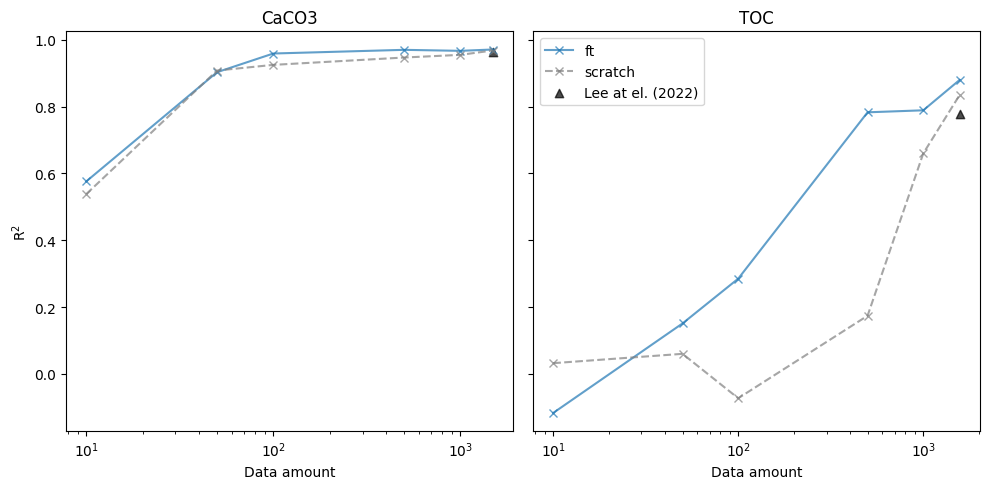

In [8]:
r2_2022 = {"CaCO3": 0.964, "TOC": 0.778}

fig, axes = plt.subplots(1, 2, sharey="row", figsize=(10, 5))

r2_df = pd.DataFrame()
for target, ax in zip(["CaCO3", "TOC"], axes):
    data_no = df.loc[df["target"] == target, "data_no"].values
    r2_ft = df.loc[df["target"] == target, "r2_ft"].values
    r2_scratch = df.loc[df["target"] == target, "r2_scratch"].values
    #data_no_str = df.loc[df["target"] == target, "data_no"].astype(str).values

    ax.plot(data_no, r2_ft, label="ft", marker="x", alpha=0.7)
    ax.plot(data_no, r2_scratch, label="scratch", marker="x", ls="--", alpha=0.7, c="gray")
    ax.scatter(data_no[-1], r2_2022[target], marker="^", label="Lee at el. (2022)", alpha=0.7, c="black")
    #for x, y, s in zip(data_no, r2_scratch, data_no_str):
    #    ax.text(x, y-0.1, s, ha="left", va="top")

    ax.set_xlabel("Data amount")
    ax.set_title(target)
    ax.set_xscale("log")

axes[1].legend()
axes[0].set_ylabel("R$^2$")
plt.tight_layout()

Both CaCO3 and TOC models fine-tuned from the pre-trained model outperform the train-from-scratch model, especially at TOC. Also, they outperform the SVM models, which are trained by the whole dataset (Lee et al., 2022), starting from only using 500 data points for training. This clearly shows the benefit of pre-training: reducing data for training. Besides, the capacity of the ViT model is proved to be powerful in these tasks because the train-from-scratch models are able to catch up to the pre-trained models during the increasing of data points.

Interestingly, the TOC quantification, which is commonly believed to be difficult due to the lack of direct XRF signal, behaves very well in our approach. 